In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import sys
sys.path.append('../code/utils/')
sys.path.append('../code/feature/')
import data_utils as du
import perf_utils as pu
from clickrate import BayesianSmoothedClickrate

In [2]:
df_train = du.load_raw_data("train")
df_train["newLabel"] = (df_train['label'] + 1) / 2
df_user = df_train.groupby('uid')['newLabel']

In [3]:
user_count = df_user.size().reset_index()[["uid", "newLabel"]].rename(columns={"newLabel": "count"})
user_click = df_user.sum().reset_index()[["uid", "newLabel"]].rename(columns={"newLabel": "click"})
user_stats = pd.merge(user_count, user_click, on="uid")
user_stats.sort_values('count', ascending=False)

,uid,count,click
2985921,31265940,16,14.0
2624577,27479691,15,15.0
7715458,80789762,15,14.0
274233,2872218,15,11.0
7798267,81654464,14,14.0
3758079,39353958,14,11.0
7031359,73621671,14,12.0
2735132,28637723,14,3.0
4804614,50297463,14,12.0
3239518,33922364,13,11.0


In [4]:
user_stats["clickrate"] = user_stats["click"] / user_stats["count"]
user_boring = user_stats.sort_values(['clickrate', 'count'], ascending=False)
user_boring.iloc[:100000]

,uid,count,click,clickrate
2624577,27479691,15,15.0,1.0
7798267,81654464,14,14.0,1.0
7146551,74824359,13,13.0,1.0
1310448,13713323,11,11.0,1.0
205570,2151023,10,10.0,1.0
2833555,29670210,10,10.0,1.0
5394495,56466758,10,10.0,1.0
6869500,71926426,10,10.0,1.0
7576681,79337037,10,10.0,1.0
5401411,56538749,9,9.0,1.0


In [5]:
imps = user_boring["count"].values
clks = user_boring["click"].values

In [8]:
bsc_user = BayesianSmoothedClickrate(use_moment=True, use_fixed_point=False)
bsc_user.fit(imps, clks)
print(bsc_user.alpha, bsc_user.beta)
print("Expectation of Click Rate: {:6f}".format(bsc_user.alpha / bsc_user.beta))

0.002667817972366256 0.05707532085808121
Expectation of Click Rate: 0.046742


In [9]:
user_boring["bs_clickrate"] = bsc_user.transform(imps, clks)
user_boring  # why are you so boring lol

,uid,count,click,clickrate,bs_clickrate
2624577,27479691,15,15.0,1.0,0.996210
7798267,81654464,14,14.0,1.0,0.995941
7146551,74824359,13,13.0,1.0,0.995630
1310448,13713323,11,11.0,1.0,0.994839
205570,2151023,10,10.0,1.0,0.994326
2833555,29670210,10,10.0,1.0,0.994326
5394495,56466758,10,10.0,1.0,0.994326
6869500,71926426,10,10.0,1.0,0.994326
7576681,79337037,10,10.0,1.0,0.994326
5401411,56538749,9,9.0,1.0,0.993700


In [10]:
uid_to_bs = dict(zip(user_boring['uid'].values, user_boring['bs_clickrate'].values))

In [11]:
df_test = du.load_raw_data("test")
user_test = df_test.groupby('uid')['aid']
user_test = user_test.size().reset_index()[["uid", "aid"]].rename(columns={"aid": "count"})
user_test.sort_values('count', ascending=False)

,uid,count
245452,9213386,8
372791,14013342,7
334834,12567148,7
823793,30984441,7
193999,7275859,6
523743,19692870,6
1599114,60115163,6
1447748,54426461,6
141921,5313075,6
2018324,75885747,6


In [12]:
default_bs = bsc_user.alpha / bsc_user.beta
user_test["bs_clickrate"] = user_test['uid'].apply(lambda x: uid_to_bs.get(x, np.nan))

In [13]:
user_test.isnull().sum()

uid                   0
count                 0
bs_clickrate    1803487
dtype: int64

In [14]:
user_test_boring = user_test.sort_values('bs_clickrate', ascending=False)
user_test_boring.iloc[:18500]

,uid,count,bs_clickrate
2172286,81654464,1,0.995941
1990128,74824359,4,0.995630
364851,13713323,3,0.994839
789065,29670210,2,0.994326
1912974,71926426,3,0.994326
1502026,56466758,2,0.994326
57757,2151023,1,0.994326
2110625,79337037,2,0.994326
1503961,56538749,3,0.993700
1856425,69802420,2,0.993700


In [15]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits)
split_indices = [(train_index, valid_index) for train_index, valid_index in skf.split(df_train, df_train['label'])]

In [17]:
X = df_train['uid']
y = df_train['label']
y = (y + 1) / 2

In [33]:
pred = np.zeros(df_train.shape[0])
aucs = np.zeros(n_splits)
loglosses = np.zeros(n_splits)

for i, (train_index, valid_index) in enumerate(split_indices):
    # split train/valid sets
    print("[{}] Start Fold #{}.".format(pu.get_time_str(), i))
    X_train, y_train = df_train.iloc[train_index], y[train_index]
    X_valid, y_valid = df_train.iloc[valid_index], y[valid_index]

    # prepare impressions and clicks data
    train_user = X_train.groupby('uid')['newLabel']
    train_count = train_user.size().reset_index()[["uid", "newLabel"]].rename(columns={"newLabel": "count"})
    train_click = train_user.sum().reset_index()[["uid", "newLabel"]].rename(columns={"newLabel": "click"})
    train_stats = pd.merge(train_count, train_click, on="uid")
    train_imps = train_stats['count'].values
    train_clks = train_stats['click'].values

    # fit bayesian smoothing model
    print("[{}] Solving Click Rate with Bayesian Smoothing...".format(pu.get_time_str()))
    bsc_train = BayesianSmoothedClickrate(use_moment=True, use_fixed_point=False)
    bsc_train.fit(train_imps, train_clks)
    expected_bs = bsc_train.alpha / bsc_train.beta
    print("[{}] Done. Expectation of Click Rate: {:6f}".format(pu.get_time_str(), expected_bs))

    # make prediction with bayesian smooting
    train_stats['bs_clickrate'] = bsc_train.transform(train_imps, train_clks)
    bsc_dict = dict(zip(train_stats['uid'].values, train_stats['bs_clickrate'].values))
    pred_valid = X_valid['uid'].apply(lambda x: bsc_dict.get(x, expected_bs))
    pred[valid_index] = pred_valid

    # calculate score
    auc = metrics.roc_auc_score(y_valid, pred_valid)
    aucs[i] = auc
    logloss = metrics.log_loss(y_valid, pred_valid)
    loglosses[i] = logloss
    print("[{}] AUC: {} Logloss: {}".format(pu.get_time_str(), auc, logloss))
    
print("AUC Mean: {} AUC Std: {}".format(np.mean(aucs), np.std(aucs)))
print("Logloss Mean: {} Logloss Std: {}".format(np.mean(loglosses), np.std(loglosses)))

[14:41:36] Start Fold #0.
[14:41:42] Solving Click Rate with Bayesian Smoothing...
[14:42:09] Done. Expectation of Click Rate: 0.047480
[14:42:15] AUC: 0.5281895157589696 Logloss: 0.2172154409823271
[14:42:15] Start Fold #1.
[14:42:20] Solving Click Rate with Bayesian Smoothing...
[14:42:48] Done. Expectation of Click Rate: 0.047477
[14:42:54] AUC: 0.5256931191314265 Logloss: 0.21776569839834906
[14:42:54] Start Fold #2.
[14:43:00] Solving Click Rate with Bayesian Smoothing...
[14:43:28] Done. Expectation of Click Rate: 0.047517
[14:43:33] AUC: 0.5271827154172191 Logloss: 0.21759094871501536
AUC Mean: 0.5270217834358717 AUC Std: 0.0010254830918376679
Logloss Mean: 0.21752402936523052 Logloss Std: 0.0002295712750665373


In [34]:
auc = metrics.roc_auc_score(y, pred)
logloss = metrics.log_loss(y, pred)
print("AUC: {} Logloss: {}".format(auc, logloss))

AUC: 0.5271289432077239 Logloss: 0.2175240293225536


In [38]:
fpr, tpr, _ = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)

In [45]:
plt.close()
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

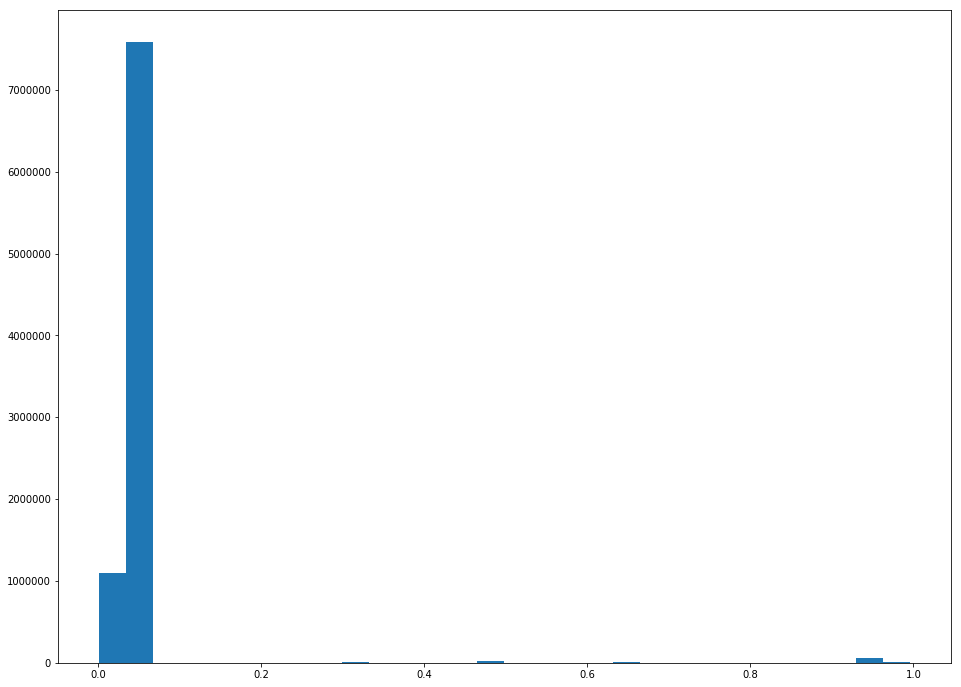

In [60]:
plt.figure(figsize=(16, 12))
plt.hist(pred, bins=30)
plt.show()